In [72]:
import utils

import cv2
import os
from tensorflow import keras
import albumentations as albu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segmentation_models as sm
from sklearn.model_selection import train_test_split

sm.set_framework('tf.keras')
sm.framework()

#BASED ON: https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

'tf.keras'

In [13]:
X_images, y_images = utils.load_all_images()
X_images, _ = zip(*X_images)

X_train = X_images[:-6]
y_train = y_images[:-6]

X_test = X_images[-6:]
y_test = y_images[-6:]

Loading sets ('dr', 'g', 'h') of images: 100%|█████████████████████████████████████████| 15/15 [00:11<00:00,  1.27it/s]


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [15]:
shape = y_train[0].shape[0]

In [70]:
class Dataset:
    
    CLASSES = ['blood_vessel']
    
    def __init__(
            self, 
            images, 
            masks, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images = images
        self.masks = masks
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes] # add +1 to index toavoid inverting the image
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        new_shape = (960, 640)
        
        # read data
        image = self.images[i]
        image = cv2.resize(image, new_shape)

        mask = self.masks[i]
        mask = cv2.resize(mask, new_shape, interpolation=cv2.INTER_NEAREST)
        _, mask = cv2.threshold(mask, 0.5, 1,cv2.THRESH_BINARY)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloader(keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

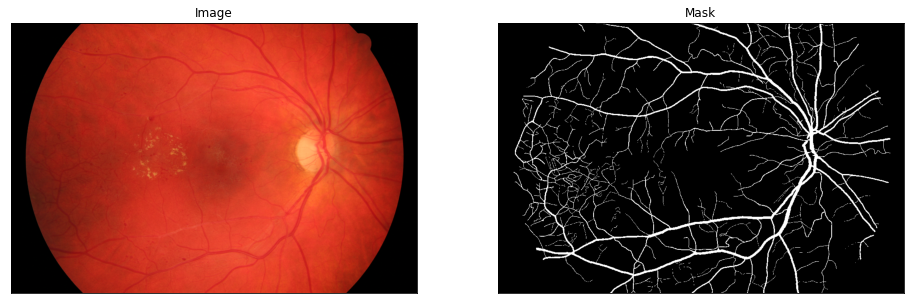

In [65]:
dataset = Dataset(X_train, y_train, classes=['blood_vessel'])

image, mask = dataset[5] 
utils.visualize(
    image=image, 
    mask=mask[..., 0].squeeze()
)

In [53]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.2),
        albu.ShiftScaleRotate(p=0.6, border_mode=0),
        albu.PadIfNeeded(min_height=640, min_width=960, always_apply=True, border_mode=0),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.Sharpen(p=0.3, lightness=(0, 0.1), alpha=(0.2, 0.3)),
                albu.Blur(blur_limit=3, p=0.3),
                albu.MotionBlur(blur_limit=3, p=0.3),
            ],
            p=0.9,
        ),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(640, 960)
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

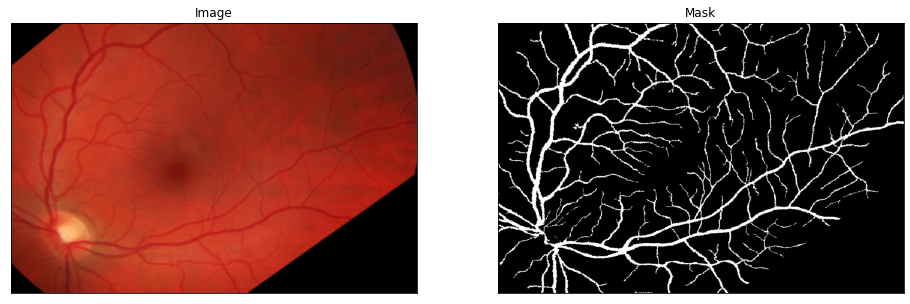

In [68]:
dataset = Dataset(X_train, y_train, classes=['blood_vessel'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
utils.visualize(
    image=image, 
    mask=mask[..., 0].squeeze(),
)

# Model

In [41]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['blood_vessel']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [42]:
n_classes = 1 
activation = 'sigmoid'

model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [43]:
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

In [44]:
train_dataset = Dataset(
    X_train, 
    y_train, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset = Dataset(
    X_valid, 
    y_valid, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

curr_dir_path = os.path.abspath('')
model_dir_path = os.path.join(curr_dir_path, "models")
model_path = os.path.join(model_dir_path, f"best_model_unet.h5")

assert train_dataloader[0][0].shape == (BATCH_SIZE, 640, 960, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 640, 960, n_classes)

callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [45]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
17/17 [==============================] - 485s 28s/step - loss: 0.4239 - iou_score: 0.5638 - f1-score: 0.7167 - val_loss: 1.8852 - val_iou_score: 0.0020 - val_f1-score: 0.0041 - lr: 1.0000e-04
Epoch 2/40
17/17 [==============================] - 550s 33s/step - loss: 0.2978 - iou_score: 0.7920 - f1-score: 0.8827 - val_loss: 0.9808 - val_iou_score: 0.0547 - val_f1-score: 0.0991 - lr: 1.0000e-04
Epoch 3/40
17/17 [==============================] - 598s 35s/step - loss: 0.2365 - iou_score: 0.8779 - f1-score: 0.9345 - val_loss: 0.5022 - val_iou_score: 0.3477 - val_f1-score: 0.4665 - lr: 1.0000e-04
Epoch 4/40
17/17 [==============================] - 667s 39s/step - loss: 0.2023 - iou_score: 0.9032 - f1-score: 0.9489 - val_loss: 0.2895 - val_iou_score: 0.7233 - val_f1-score: 0.8387 - lr: 1.0000e-04
Epoch 5/40
17/17 [==============================] - 733s 43s/step - loss: 0.1881 - iou_score: 0.9077 - f1-score: 0.9514 - val_loss: 0.2113 - val_iou_score: 0.8871 - val_f1-score: 0.9402 - 

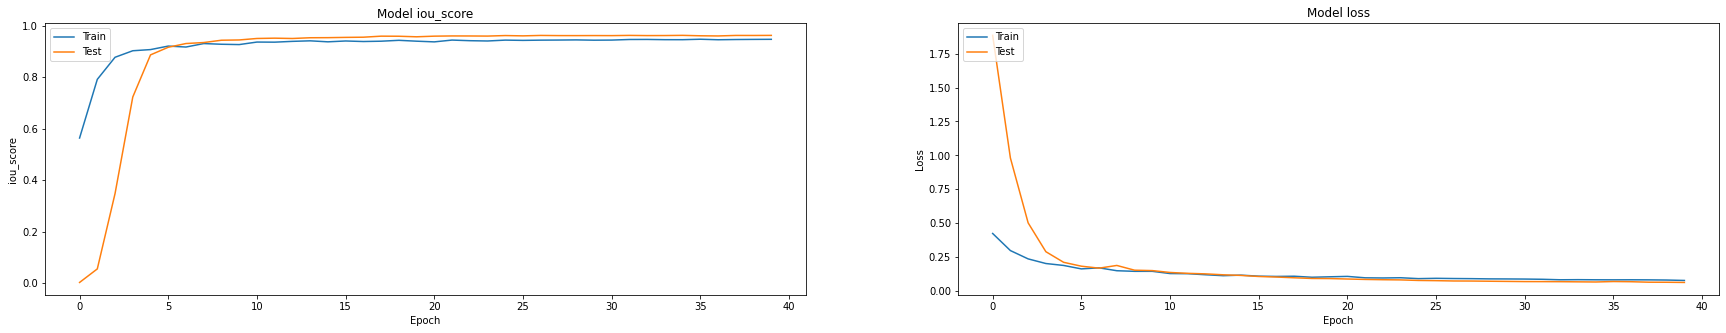

In [69]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model evaluation

In [54]:
test_dataset = Dataset(
    X_test, 
    y_test, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [48]:
model.load_weights(model_path) 

In [55]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

6/6 [==============================] - 9s 1s/step - loss: 0.0652 - iou_score: 0.9614 - f1-score: 0.9803
Loss: 0.065215
mean iou_score: 0.96139
mean f1-score: 0.98031


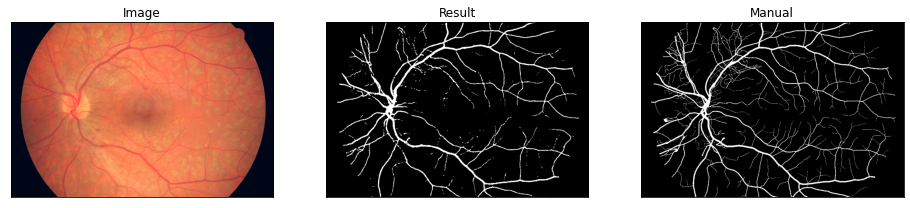

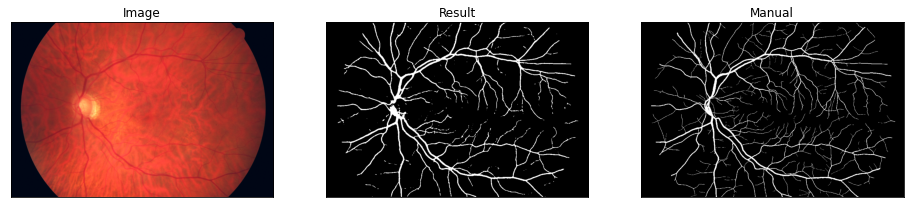

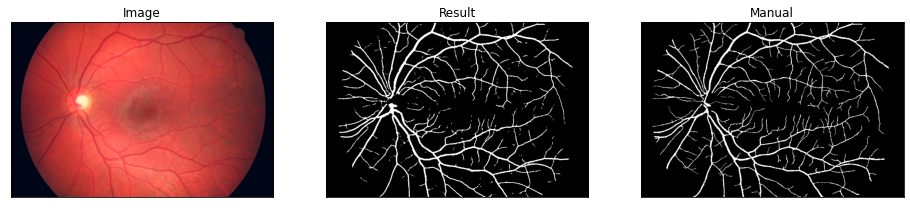

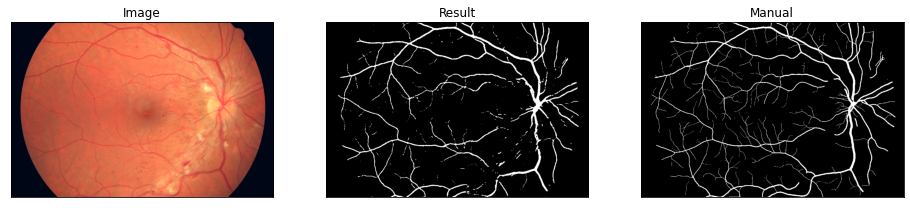

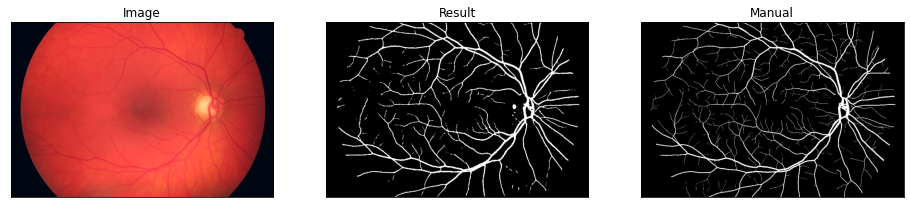

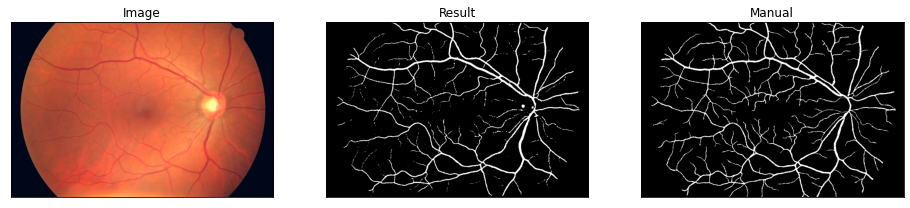

In [75]:
for i in range(6):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    utils.visualize(
        image=utils.denormalize(image.squeeze()),
        result=1-pr_mask[..., 0].squeeze(),  # delete "1-" if you trained on not inverted images
        manual=1-gt_mask[..., 0].squeeze(),  # delete "1-" if you trained on not inverted images
    )